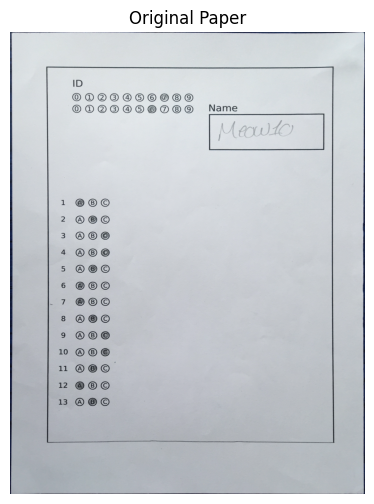

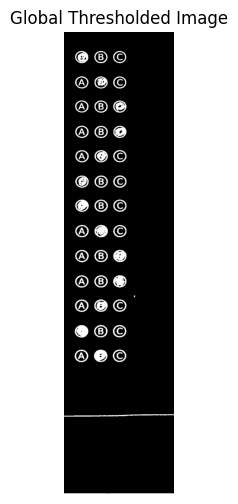

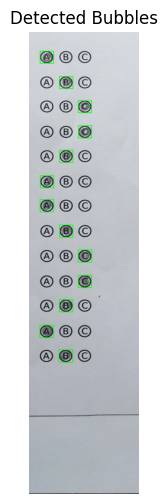

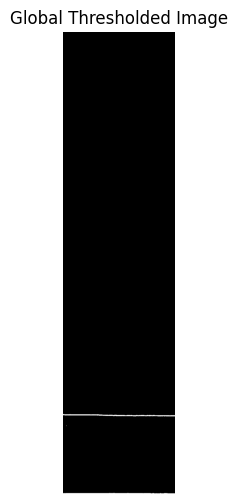

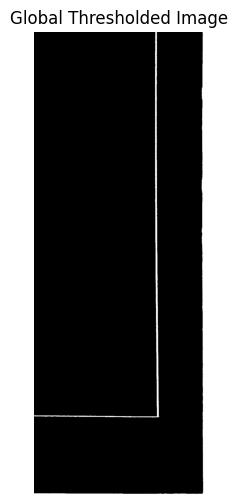

Detected Answers: ['A', 'B', 'C', 'C', 'B', 'A', 'A', 'B', 'C', 'C', 'B', 'A', 'B']


In [23]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from imutils import contours
import imutils
from paperExtraction import *
from utils import *

# Automatic bubble detection for one column
def detectColumnAnswers(columnImage):
    # Parameters to segment the bubbles accurately and prevent noise treated as bubbles
    bubbleMinSize = 10 # Min size of bubble is 10
    aspectRatioTolerance = 0.2 # To prevent irregular circular bubbles
    minFillRatio = 0.6 # How filled is the bubble
    rowGapMultiplier = 3.0
    multipleTolerance = 0.05

    # Converting to gray scale and applying global thresholding
    # Found it better than adaptive thresholding
    # Background is black and foreground objects are white
    grayScale = cv.cvtColor(columnImage, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(grayScale, 150, 255, cv.THRESH_BINARY_INV)
    show_image(binary, "Global Thresholded Image")

    # Only outer contours are detected to ignore inner noise
    allContours = cv.findContours(binary.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    allContours = imutils.grab_contours(allContours)

    bubbleContours = []
    for contour in allContours:
        x, y, width, height = cv.boundingRect(contour)
        aspectRatio = float(width) / float(height)
        # This is a bubble
        if width >= bubbleMinSize and height >= bubbleMinSize and abs(aspectRatio - 1) <= aspectRatioTolerance:
            bubbleContours.append(contour)
    if not bubbleContours:
        return []

    # Contours have contours themselves as points or bounding boxes as object of (x, y, w, h)
    bubbleContours = contours.sort_contours(bubbleContours, method = "top-to-bottom")[0]

    # Grouping into rows by y coordinate
    rows = []
    currentRow = []
    rowHeightTolerance = 5
    for contour in bubbleContours:
        x, y, width, height = cv.boundingRect(contour)
        if not currentRow:
            currentRow = [contour]
            currentRowY = y
        elif abs(y - currentRowY) <= rowHeightTolerance:
            currentRow.append(contour)
        else:
            # Sorting with respect to x coordinate before appending
            rows.append(sorted(currentRow, key = lambda r: cv.boundingRect(r)[0]))
            currentRow = [contour]
            currentRowY = y
    if currentRow:
        rows.append(sorted(currentRow, key = lambda r: cv.boundingRect(r)[0]))

    letters = ['A','B','C','D','E']
    answers = []
    detectedBubblesImage = columnImage.copy()
    rowReferenceY = None
    rowHeights = []

    for row in rows:
        ys = [cv.boundingRect(c)[1] for c in row]
        hs = [cv.boundingRect(c)[3] for c in row]
        rowY = int(np.mean(ys))
        rowHeight = int(np.mean(hs))
        rowHeights.append(rowHeight)
        avgHeight = np.mean(rowHeights)

        # Detects last question row in bubble sheet
        if rowReferenceY is not None and (rowY - rowReferenceY) > rowGapMultiplier * avgHeight:
            break
        rowReferenceY = rowY

        choices = row
        fillRatios = []
        for choice in choices:
            # Isolating just this bubble.
            mask = np.zeros(binary.shape, dtype="uint8")
            cv.drawContours(mask, [choice], -1, 255, -1)
            filledPixels = cv.countNonZero(cv.bitwise_and(binary, binary, mask=mask))
            bubbleArea = cv.countNonZero(mask)
            if bubbleArea == 0:  # Prevent division by zero
                fillRatios.append(0)
            else:
                fillRatios.append(filledPixels / float(bubbleArea))

        maxFillRatio = max(fillRatios)
        filledIndices = []

        if maxFillRatio != 0:  # Prevent division by zero
            for i, ratio in enumerate(fillRatios):
                if (maxFillRatio - ratio) / maxFillRatio <= multipleTolerance and maxFillRatio >= minFillRatio:
                    filledIndices.append(i)


        if len(filledIndices) == 0:
            answers.append("Z")  # empty
        elif len(filledIndices) > 1:
            answers.append("X")  # multiple
        else:
            index = filledIndices[0]
            answers.append(letters[index])
            x, y, width, height = cv.boundingRect(choices[index])
            cv.rectangle(detectedBubblesImage, (x, y), (x  + width, y + height), (0, 255, 0), 2)

    show_image(detectedBubblesImage, "Detected Bubbles")
    return answers


imagePath = "../data/images/8.jpg"
paper = extractPaper(imagePath)

height, width, channels = paper.shape
questionImage = paper[height // 3:, :, :]

column1 = questionImage[:, int(0.164 * width):int(0.37 * width), :]
column2 = questionImage[:, int(0.42 * width):int(0.63 * width), :]
column3 = questionImage[:, int(0.68 * width): width, :]

show_image(paper, "Original Paper")

answersCol1 = detectColumnAnswers(column1)
answersCol2 = detectColumnAnswers(column2)
answersCol3 = detectColumnAnswers(column3)

allAnswers = answersCol1 + answersCol2 + answersCol3

print("Detected Answers:", allAnswers)
